In [1]:
%%capture
from numpy.random import rand

# import sys
# !{sys.executable} -m pip install --user funcy

import importlib
import policies
import config
import state_updates
import utils

importlib.reload(config)
importlib.reload(policies)
importlib.reload(state_updates)
importlib.reload(utils)

initial_conditions, rarity, market_settings = config.initial_conditions, config.rarity, config.market_settings

In [2]:
num_runs = 2

def player_active():
    awake_likelihood = 0.6  # 60% probability of player being awake
    active_likelihood = 0.3 # 30% probability of being active, given they are awake
    return rand() < (awake_likelihood*active_likelihood)

params = {
    'duration': 60, # duration of timestep (in minutes)
    'player_active': player_active
}

simulation_parameters = {
    'T': range(100),
    'N': num_runs,
    'M': params
}


initialized_conditions = utils.initialize(market_settings, initial_conditions)



# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, 
# the user specifies if state update functions will be run in series or in parallel
# and the policy functions that will be evaluated in that block
partial_state_update_blocks = [
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'playerPolicy': policies.player_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            'network': state_updates.update_network,
            'bc-totalSupply': state_updates.bc_totalSupply,
            'symmetries': state_updates.update_symmetries,
            #'bc-balance': state_updates.bc_balance,
        }
    }
]

# partial_state_update_blockzzzs = [
#     miner_interactions, # miners who only take rewards and run at defined hashrates
#     player_interactions, # players who are sporadically playing, low hash rates, probabilistic buy/sell
#     market_interactions, # players who buy / sell clovers from market
#     speculators # folks speculating on clovercoin price
# ]

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



from cadCAD.configuration import Configuration
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initialized_conditions.copy(), #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

from cadCAD import configs

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

single_proc: [<cadCAD.configuration.Configuration object at 0x7fd7ce9a3278>]


In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import math


def to_df(raw_result):
    def flatten_cols(row):
        g = row['network']
        new_cols = {}

        
        players = utils.get_nodes_by_type(g, 'player')
        clovers = utils.get_nodes_by_type(g, 'clover')
        
        new_cols['players'] = len(players)
        new_cols['clovers'] = len(clovers)
        new_cols['bankClovers'] = len([x for x in clovers if utils.owner_type(g, x) == 'bank'])
        new_cols.update(row['symmetries'])
        # new_cols['playerClovers'] = new_cols['clovers'] = new_cols['bankClovers']
        # for clover_attr in ['hasSymmetry', 'y0Sym', 'x0Sym', 'xySym', 'xnySym', 'rotSym', 'pretty']:
        #     new_cols['net_' + clover_attr] = len([c for c in clovers if g.nodes[c][clover_attr]])

        res = {**row, **new_cols}
        res.pop('network')
        res.pop('symmetries')
        
        return res

    return pd.DataFrame(map(flatten_cols, raw_result))

df = to_df(raw_result)

# adding new useful columns for graphing
df['coin-price'] = utils.calculateCurrentPrice(
    (df['bc-totalSupply'] + market_settings['bc-virtualSupply']),
    (df['bc-balance'] + market_settings['bc-virtualBalance']),
    market_settings['bc-reserveRatio'])

df

,bankClovers,bc-balance,bc-totalSupply,clovers,hasSymmetry,players,rotSym,run,substep,timestep,x0Sym,xnySym,xySym,y0Sym,coin-price
0,0,40,30297.222283,0,0,20,0,1,0,0,0,0,0,0,0.001681
1,5,40,30328.472283,8,8,20,2,1,1,1,0,3,3,0,0.001680
2,22,40,30465.822283,35,35,20,3,1,1,2,5,14,9,4,0.001679
3,25,40,30488.422283,39,39,20,3,1,1,3,6,17,9,4,0.001678
4,38,40,30614.422283,57,57,20,4,1,1,4,9,23,15,5,0.001677
5,52,40,30882.522283,79,79,20,7,1,1,5,9,30,23,9,0.001673
6,56,40,30870.672283,83,83,20,7,1,1,6,9,33,23,9,0.001673
7,59,40,31113.372283,91,91,20,8,1,1,7,10,34,26,11,0.001670
8,72,40,31224.372283,107,107,20,9,1,1,8,10,39,34,12,0.001669
9,75,40,31521.122283,115,115,20,9,1,1,9,11,41,38,13,0.001665


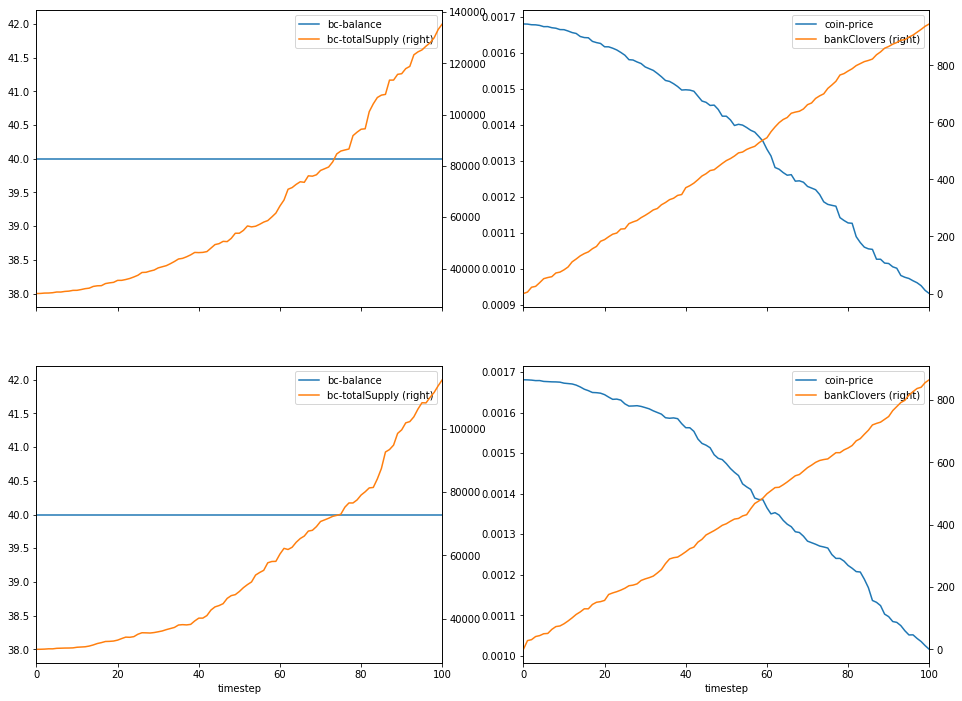

In [4]:
fig = plt.figure(figsize=(16,6*num_runs))
axs = fig.subplots(num_runs, 2)

for run in range(0,num_runs):
    df[df.run == (run+1)].plot('timestep', ['bc-balance', 'bc-totalSupply'], secondary_y=['bc-totalSupply'], ax=axs[run,0])
    df[df.run == (run+1)].plot('timestep', ['coin-price', 'bankClovers'], secondary_y=['bankClovers'], ax=axs[run,1])

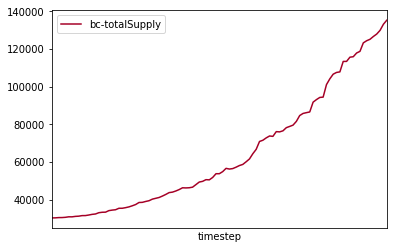

In [5]:
df_run = df[df.run == 1]
df_run.plot('timestep', ['bc-totalSupply'], grid=False, 
        xticks=[], 
        colormap = 'RdYlGn',
       )

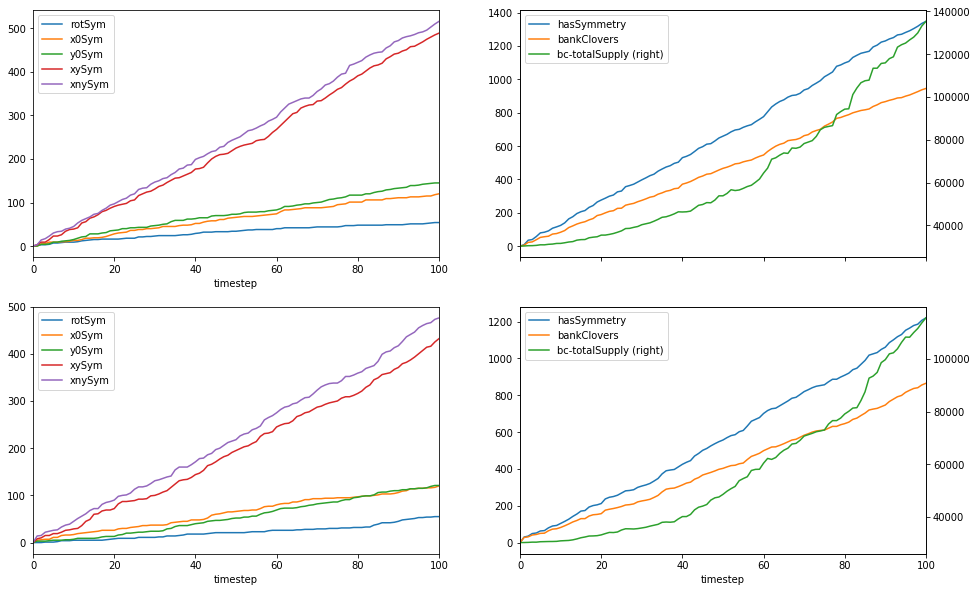

In [7]:
row_height = 5
# set a figure with initial dimensions
fig = plt.figure(figsize=(16,(row_height*num_runs)))

# create 2 axes (2 graphs) laid out in a 1x2 grid, and set them each to a variable
axs = fig.subplots(num_runs, 2)

for row_idx in range(0,num_runs):
    df_run = df[df.run == (row_idx + 1)]
    # draw out all the symmetries in a single graph, on ax1 (the left graph)
    df_run.plot('timestep', ['rotSym', 'x0Sym', 'y0Sym', 'xySym', 'xnySym'], grid=False, 
            ax=axs[row_idx,0]
           )
    
    # draw out the bank clovers and total symms on ax2 (the right graph)
    df_run.plot('timestep', ['hasSymmetry','bankClovers'], ax=axs[row_idx,1])
    
    # additionally draw out the totalSupply as a secondary axis on ax2 (the right graph)
    df_run.plot('timestep','bc-totalSupply',secondary_y=True, ax=axs[row_idx,1])

In [28]:
import numpy

syms = {
    'rotSym': 38,
    'x0Sym': 109,
    'xySym': 380,
    'xnySym': 442,
    'diagRotSym': 14,
    'perpRotSym': 4,
    'allSym': 4
}

totalSyms = numpy.sum(list(syms.values()))

for k,v in syms.items():
    syms[k] = v/totalSyms
    
syms

{'rotSym': 0.03834510595358224,
 'x0Sym': 0.1099899091826438,
 'xySym': 0.3834510595358224,
 'xnySym': 0.44601412714429867,
 'diagRotSym': 0.014127144298688193,
 'perpRotSym': 0.004036326942482341,
 'allSym': 0.004036326942482341}

In [81]:
rand_val = rand()

def whichSymmetry(): 
    for i in range(1,len(syms)+1):
        if rand_val <= numpy.sum(list(syms.values())[0:i]):
            break;

    list(syms.keys())[i-1]

'xnySym'

In [201]:
g = utils.initialize_network(30,5)

In [202]:

g

In [205]:
utils.get_nodes_by_type(g, "bank")[0]

35